In [ ]:
!cp /kaggle/input/dpo-llm-lavita/gpt_download.py /kaggle/working/
!cp /kaggle/input/dpo-llm-lavita/instruction-data-with-preference-1.json /kaggle/working/
!cp /kaggle/input/dpo-llm-lavita/utils.py /kaggle/working/

In [ ]:
!cp /kaggle/input/gpt-model-small-lavita/gpt2-small-lavita-sft.pth /kaggle/working/

In [ ]:
!pip install tiktoken

In [1]:
import torch
import tiktoken

In [2]:
import json


file_path = "instruction-data-with-preference-1.json"

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print("Number of entries:", len(data))

Number of entries: 1197


In [3]:
import pprint

pprint.pp(data[50])

{'instruction': 'If you are a doctor, please answer the medical questions '
                "based on the patient's description.",
 'input': 'My daughter presented to the Er 2 days ago with severe vomiting , '
          'diarrhea and abdominal pain. Was sent home after being given zofran '
          'and IV. Returned to er few hours later with same symptoms, and was '
          'diagnosed 14 hours later with appendicitis through a cat scanned '
          'vey inflamed appendix. Fever 101 .3. Pulse 118 bp under 100, we had '
          'to push and insist for her to have her surgery performed within 10 '
          'hours of diagnosis versus 16 hours. So she had fever, was in pain '
          'for 10 hours sgter diagnosed, had laparoscopic surgery, all went '
          'well, any thing to look for du to the delay of surgery post '
          'symptoms30 hours and diagnosis 10 hrs',
 'output': 'hi ! good morning. i am chatbot answering your query. if every '
           'thing went well with

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
My daughter presented to the Er 2 days ago with severe vomiting , diarrhea and abdominal pain. Was sent home after being given zofran and IV. Returned to er few hours later with same symptoms, and was diagnosed 14 hours later with appendicitis through a cat scanned vey inflamed appendix. Fever 101 .3. Pulse 118 bp under 100, we had to push and insist for her to have her surgery performed within 10 hours of diagnosis versus 16 hours. So she had fever, was in pain for 10 hours sgter diagnosed, had laparoscopic surgery, all went well, any thing to look for du to the delay of surgery post symptoms30 hours and diagnosis 10 hrs


In [5]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
hi ! good morning. i am chatbot answering your query. if every thing went well with the surgery, you do not have to worry much. only factor you should be watchful is if she got any fever or increasing pain abdomen or any other abnormal symptom post-operative specially after 2-3 days or later. in that case, you should report back to the treating surgeon / er of the nearest hospital. i hope this information would help you in discussing with your family physician/treating doctor in further management of your problem. please do not hesitate to ask in case of any further doubts. thanks for choosing chatbot to clear doubts on your health problems. wishing you an early recovery. chatbot.
### Response:
Here is the rewritten output:

`Listen up! Good morning, I suppose. If everything went smoothly with the surgery, don't worry too much. Just keep an eye out for fever or increasing abdominal pain or any other weird symptoms post-op, especially after 2-3 days or later. If you notice

In [6]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [7]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [8]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # Initialize lists to hold batch data
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []

    }

    # Determine the longest sequence to set a common padding length
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key])+1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item in the batch
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # Adjust padding according to the common maximum length
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # Set mask for all padding tokens to False
            mask[len(sequence):] = False

            # Set mask for all input tokens to False
            # +2 sets the 2 newline ("\n") tokens before "### Response" to False
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # Final processing
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # Stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key])

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # Move to the specified device
        batch_data[key] = tensor_stack.to(device)

    return batch_data

In [9]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # Put the data directly on a GPU if available
    mask_prompt_tokens=True,  # This is optional
    allowed_max_length=1024   # The supported context length of the model
)

Device: cuda


In [10]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'If you are a doctor, please answer the medical questions '
                "based on the patient's description.",
 'input': 'Hi, may I answer your health queries right now ?  i am constantly '
          'having mood swings . i get angry on the smallest issue and tend to '
          'overreact. this is affecting me physically and mentally. i even go '
          'to the extent of hurting myself or someone else. please help.',
 'output': 'hi, thanks for writing. i have understood your concerns.frequent '
           'mood swings can be a part of bipolar disorder [mania and '
           'depression], reaction to stress, personality problem [borderline '
           'personality disorder].usually bipolar mania patient do not have '
           'insight for their illness. so you must be suffering from bipolar '
           'depression but you shut go for your personality evaluation also '
           'because frequent and rapid mood changes with tendency to harm '
           'on

In [11]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

In [12]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


In [13]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

In [14]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # [0] for the first entry in the batch
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
Hi, may I answer your health queries right now ?  i am constantly having mood swings . i get angry on the smallest issue and tend to overreact. this is affecting me physically and mentally. i even go to the extent of hurting myself or someone else. please help.


In [15]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
Hi, may I answer your health queries right now ?  i am constantly having mood swings . i get angry on the smallest issue and tend to overreact. this is affecting me physically and mentally. i even go to the extent of hurting myself or someone else. please help.

### Response:
Here is the rewritten output:

Hi, thank you for reaching out with your concerns. I understand that frequent mood swings can be a part of various conditions, including bipolar disorder [mania and depression], reaction to stress, or personality problems [borderline personality disorder]. It's possible that you may be experiencing symptoms of bipolar depression, but it's also important to consider the possibility of a personality issue given your tendency to harm yourself or others. Addition

In [16]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
Hi, may I answer your health queries right now ?  i am constantly having mood swings . i get angry on the smallest issue and tend to overreact. this is affecting me physically and mentally. i even go to the extent of hurting myself or someone else. please help.

### Response:
hi, thanks for writing. i have understood your concerns.frequent mood swings can be a part of bipolar disorder [mania and depression], reaction to stress, personality problem [borderline personality disorder].usually bipolar mania patient do not have insight for their illness. so you must be suffering from bipolar depression but you shut go for your personality evaluation also because frequent and rapid mood changes with tendency to harm oneself is more going towards personality issues.moo

In [17]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 2

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([2, 470]) torch.Size([2, 470])
torch.Size([2, 171]) torch.Size([2, 171])
torch.Size([2, 345]) torch.Size([2, 345])
torch.Size([2, 447]) torch.Size([2, 447])
torch.Size([2, 321]) torch.Size([2, 321])
torch.Size([2, 375]) torch.Size([2, 375])
torch.Size([2, 518]) torch.Size([2, 518])
torch.Size([2, 479]) torch.Size([2, 479])
torch.Size([2, 355]) torch.Size([2, 355])
torch.Size([2, 491]) torch.Size([2, 491])
torch.Size([2, 365]) torch.Size([2, 365])
torch.Size([2, 382]) torch.Size([2, 382])
torch.Size([2, 277]) torch.Size([2, 277])
torch.Size([2, 239]) torch.Size([2, 239])
torch.Size([2, 242]) torch.Size([2, 242])
torch.Size([2, 360]) torch.Size([2, 360])
torch.Size([2, 449]) torch.Size([2, 449])
torch.Size([2, 273]) torch.Size([2, 273])
torch.Size([2, 264]) torch.Size([2, 264])
torch.Size([2, 220]) torch.Size([2, 220])
torch.Size([2, 448]) torch.Size([2, 448])
torch.Size([2, 319]) torch.Size([2, 319])
torch.Size([2, 318]) torch.Size([2, 318])
torch.Size([2, 257])

In [18]:
import os
from pathlib import Path
import shutil


finetuned_model_path = Path("gpt2-small-lavita-sft.pth")
if not finetuned_model_path.exists():

    # Try finding the model checkpoint locally:
    relative_path =  "model" / finetuned_model_path
    if relative_path.exists():
        shutil.copy(relative_path, ".")

    # If this notebook is run on Google Colab, get it from a Google Drive folder
    elif "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ:
        from google.colab import drive
        drive.mount("/content/drive")
        google_drive_path = "/content/drive/My Drive/Books/LLMs-From-Scratch/ch07/colab/gpt2-medium355M-sft.pth"  # Readers need to adjust this path
        shutil.copy(google_drive_path, ".")

    else:
        print(
            f"Could not find '{finetuned_model_path}'.\n"
            "Run the `ch07.ipynb` notebook to finetune and save the finetuned model."
        )

In [19]:
from utils import GPTModel


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [20]:
model.load_state_dict(
    torch.load(
        "/kaggle/working/gpt2-small-lavita-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

In [21]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Answer this question truthfully: 'What is the effect of diarrhea on osmolarity?'
"""

In [22]:
from utils import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)


token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Answer this question truthfully: 'What is the effect of diarrhea on osmolarity?'

### Input:
What is the effect of diarrhea on osmolarity?

### Response:
The effect of diarrhea on osmolarity is decreased.


In [23]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

### Input:
What is the effect of diarrhea on osmolarity?


The effect of diarrhea on osmolarity is decreased.


In [24]:
policy_model = model

reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "/kaggle/working/gpt2-small-lavita-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()

# policy_model.to(device)
# reference_model.to(device)
policy_model = torch.nn.DataParallel(policy_model, device_ids = [0,1]).to(device)
reference_model = torch.nn.DataParallel(reference_model, device_ids = [0,1]).to(device)

In [25]:
import torch.nn.functional as F

def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.
        label_smoothing: conservativeness for DPO loss.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

In [26]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size, num_tokens)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

In [27]:
# Sample data
logits = torch.tensor(
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]])  # Shape: (2, 3)
targets = torch.tensor([0, 2])  # Shape: (2,)


# Manual loss using torch.gather
log_softmax_logits = F.log_softmax(logits, dim=1)  # Shape: (2, 3)
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(1), # Shape 2, 1
).squeeze(1)  # Shape: (2,)
manual_loss = -selected_log_probs.mean()  # Averaging over the batch


# PyTorch loss
cross_entropy_loss = F.cross_entropy(logits, targets)

print(manual_loss, cross_entropy_loss)

tensor(1.4185) tensor(1.4185)


In [28]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    ref_chosen_log_probas = compute_logprobs(
        logits=reference_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    ref_rejected_log_probas = compute_logprobs(
        logits=reference_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

In [29]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


(tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


In [30]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """Apply compute_dpo_loss_batch to a whole data loader"""

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

In [31]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """Compute the DPO loss for the training and validation dataset"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

In [32]:
from utils import generate_and_print_sample


def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # Initialize lists to track losses and tokens seen
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        policy_model.train()  # Set model to training mode

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

In [33]:
res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

Training loss: 0.6931471824645996
Validation loss: nan
Train reward margin: 0.0
Val reward margin: nan


In [34]:
for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Question: is this a 2) strong advice, 1) weak advice 0) no advice?

### Input:
Lower miR-10a-5p expression in Ta progressing tumors indicates that this microRNA could be important for later malignant potential among this group of patients.

Correct response:
>> This is a weak advice

Model response:
>> This is no advice

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
HI I have a cervical disc herniation at c5-c6 which is also impinging the spinal canal. The pain I felt was in my left arm. Lately I have started feeling some pain radiating at the back of my right leg (from my tight to knee to calf). Could this pain be related or is it something else

In [35]:
import time

start_time = time.time()

optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # value between 0.1 and 0.5
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Ep 1 (Step 000000): Train loss 0.693, Val loss nan, Train reward margins -0.002, Val reward margins nan
Ep 1 (Step 000005): Train loss 0.692, Val loss nan, Train reward margins 0.018, Val reward margins nan
Ep 1 (Step 000010): Train loss 0.691, Val loss nan, Train reward margins 0.037, Val reward margins nan
Ep 1 (Step 000015): Train loss 0.692, Val loss nan, Train reward margins 0.033, Val reward margins nan
Ep 1 (Step 000020): Train loss 0.690, Val loss nan, Train reward margins 0.058, Val reward margins nan
Ep 1 (Step 000025): Train loss 0.689, Val loss nan, Train reward margins 0.079, Val reward margins nan
Ep 1 (Step 000030): Train loss 0.690, Val loss nan, Train reward margins 0.071, Val reward margins nan
Ep 1 (Step 000035): Train loss 0.686, Val loss nan, Train reward margins 0.146, Val reward margins nan
Ep 1 (Step 000040): Train loss 0.681, Val loss nan, Train reward margins 0.241, Val reward margins nan
Ep 1 (Step 000045): Train loss 0.681, Val loss nan, Train reward margins

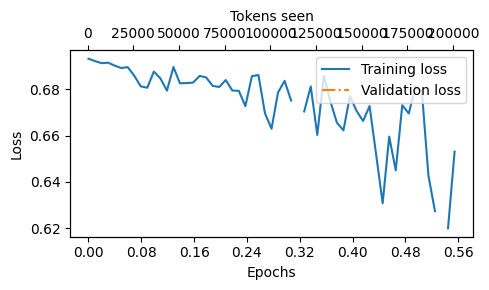

In [36]:
from utils import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    # label="loss"
)

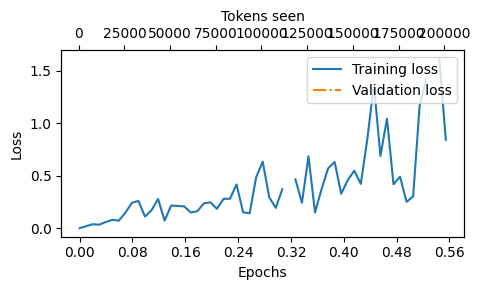

In [37]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    # label="loss"
)

In [38]:
for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Question: is this a 2) strong advice, 1) weak advice 0) no advice?

### Input:
Lower miR-10a-5p expression in Ta progressing tumors indicates that this microRNA could be important for later malignant potential among this group of patients.

Correct response:
>> This is a weak advice

Reference model response:
>> This is no advice

Policy model response:
>> !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

##

In [39]:
for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer this question truthfully

### Input:
What is the treatment for Gardnerella vaginalis?

Correct response:
>> Gardnerella vaginalis is treated with metronidazole.

Reference model response:
>> The treatment for Gardnerella vaginalis is the use of a combination of antibiotics and anti-inflammatory drugs.

Policy model response:
>> !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Please answer the letter of option truthfully

### Input:
Q:Heterozygote advantage should be most closely linked to wh